**Setup & Load**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve,
    f1_score, precision_score, recall_score
)
import pickle

# Paths
data_path = '/content/drive/MyDrive/CSE 4262 Project/Preprocessed_Churn_PySpark.csv'
model_dir = '/content/drive/MyDrive/CSE 4262 Project/XGB Model'
os.makedirs(model_dir, exist_ok=True)

# Load
df = pd.read_csv(data_path)

# X, y
X = df.drop('Churn', axis=1)
y = df['Churn']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of X: (7043, 19)
Shape of y: (7043,)


**Feature subsets**

In [27]:
features_top15 = [
    'Contract','TotalCharges','MonthlyCharges','tenure',
    'InternetService','OnlineSecurity','PaymentMethod',
    'TechSupport','OnlineBackup','gender','PaperlessBilling',
    'MultipleLines','DeviceProtection','StreamingMovies','Partner'
]

features_top11 = [
    'Contract','TotalCharges','MonthlyCharges','tenure',
    'InternetService','OnlineSecurity','PaymentMethod',
    'TechSupport','OnlineBackup','gender','PaperlessBilling'
]


**Helpers (confusion plot, PR plot, new evaluate_logistic)**

In [35]:
def plot_confusion(cm, title='Confusion Matrix'):
    plt.figure(figsize=(4.8, 4.2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.tight_layout(); plt.show()

def plot_pr_curve(y_true, y_prob, label, ax=None):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    if ax is None:
        plt.figure(figsize=(5.2, 4.4))
        plt.plot(recall, precision, label=f'{label} (AP={ap:.3f})')
        plt.xlabel('Recall'); plt.ylabel('Precision')
        plt.title('Precision–Recall Curve'); plt.legend()
        plt.tight_layout(); plt.show()
    else:
        ax.plot(recall, precision, label=f'{label} (AP={ap:.3f})')
    return precision, recall, ap

def evaluate_xgb(X, y, label, random_state=42):
    """
    - 80/20 stratified split
    - XGBoost with imbalance handling (scale_pos_weight)
    - 5-fold Stratified CV on TRAIN (Accuracy + F1)
    - Full TRAIN vs TEST metrics (Acc, ROC-AUC, F1, Precision, Recall)
    - ConfusionMatrix + returns curves & metrics
    """
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=random_state
    )

    # Compute imbalance weight for XGB
    scale_pos = (len(y_train) - sum(y_train)) / sum(y_train)

    # Model
    model = XGBClassifier(
    n_estimators=200,
    max_depth=3,               # shallower trees
    learning_rate=0.05,
    subsample=0.8,             # row sampling
    colsample_bytree=0.8,      # feature sampling
    min_child_weight=15,       # require larger leaf nodes
    gamma=1.0,                 # minimum loss reduction to split
    reg_lambda=2.2,            # L2 regularization
    reg_alpha=0.6,             # L1 regularization
    scale_pos_weight=(len(y) - sum(y)) / sum(y),
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)

    # CV on TRAIN
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_acc, cv_f1 = [], []
    for tr_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)
        cv_acc.append((y_val_pred == y_val).mean())
        cv_f1.append(f1_score(y_val, y_val_pred))

    print(f"\n[ {label} ]")
    print(f"CV Accuracy (mean±std): {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
    print(f"CV F1       (mean±std): {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

    # Final fit
    model.fit(X_train, y_train)

    # TRAIN metrics
    y_pred_tr = model.predict(X_train)
    y_prob_tr = model.predict_proba(X_train)[:, 1]
    train_metrics = {
        "accuracy": (y_pred_tr == y_train).mean(),
        "roc_auc": roc_auc_score(y_train, y_prob_tr),
        "f1": f1_score(y_train, y_pred_tr),
        "precision": precision_score(y_train, y_pred_tr, zero_division=0),
        "recall": recall_score(y_train, y_pred_tr, zero_division=0),
    }
    print(f"Train -> Acc: {train_metrics['accuracy']:.4f} | AUC: {train_metrics['roc_auc']:.4f} | "
          f"F1: {train_metrics['f1']:.4f} | P: {train_metrics['precision']:.4f} | R: {train_metrics['recall']:.4f}")

    # TEST metrics
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    test_metrics = {
        "accuracy": (y_pred == y_test).mean(),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "ap": average_precision_score(y_test, y_prob),
    }
    print(f" Test -> Acc: {test_metrics['accuracy']:.4f} | AUC: {test_metrics['roc_auc']:.4f} | "
          f"F1: {test_metrics['f1']:.4f} | P: {test_metrics['precision']:.4f} | R: {test_metrics['recall']:.4f}")

    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion(cm, title=f'Confusion Matrix – {label}')

    # Curves
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)

    return {
        "label": label,
        "model": model,
        "X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test,
        "y_pred": y_pred, "y_prob": y_prob,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "cv_acc": cv_acc, "cv_f1": cv_f1,
        "fpr": fpr, "tpr": tpr,
        "precision_curve": precision_curve, "recall_curve": recall_curve,
    }

**Train 3 variants + combined ROC/PR + metrics table & F1 bar**


[ All Features ]
CV Accuracy (mean±std): 0.7520 ± 0.0143
CV F1       (mean±std): 0.6300 ± 0.0193
Train -> Acc: 0.7714 | AUC: 0.8737 | F1: 0.6593 | P: 0.5453 | R: 0.8334
 Test -> Acc: 0.7495 | AUC: 0.8469 | F1: 0.6296 | P: 0.5181 | R: 0.8021

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9108    0.7304    0.8107      1035
           1     0.5181    0.8021    0.6296       374

    accuracy                         0.7495      1409
   macro avg     0.7145    0.7663    0.7202      1409
weighted avg     0.8066    0.7495    0.7626      1409



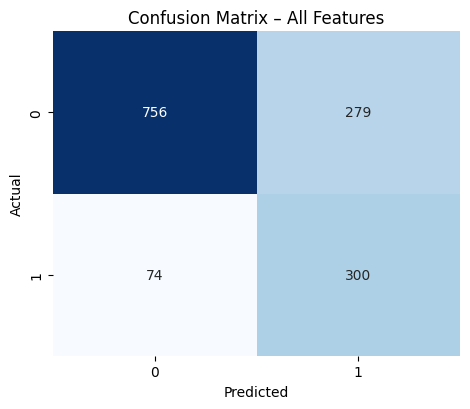


[ Top 15 Features ]
CV Accuracy (mean±std): 0.7522 ± 0.0138
CV F1       (mean±std): 0.6311 ± 0.0194
Train -> Acc: 0.7662 | AUC: 0.8713 | F1: 0.6517 | P: 0.5389 | R: 0.8241
 Test -> Acc: 0.7459 | AUC: 0.8471 | F1: 0.6247 | P: 0.5138 | R: 0.7968

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9083    0.7275    0.8079      1035
           1     0.5138    0.7968    0.6247       374

    accuracy                         0.7459      1409
   macro avg     0.7111    0.7622    0.7163      1409
weighted avg     0.8036    0.7459    0.7593      1409



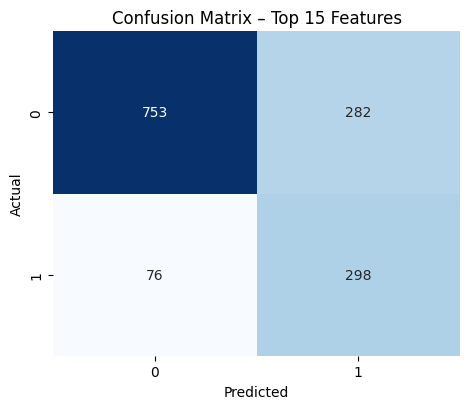


[ Top 11 Features ]
CV Accuracy (mean±std): 0.7501 ± 0.0161
CV F1       (mean±std): 0.6294 ± 0.0207
Train -> Acc: 0.7662 | AUC: 0.8698 | F1: 0.6528 | P: 0.5387 | R: 0.8281
 Test -> Acc: 0.7431 | AUC: 0.8455 | F1: 0.6237 | P: 0.5102 | R: 0.8021

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9099    0.7217    0.8050      1035
           1     0.5102    0.8021    0.6237       374

    accuracy                         0.7431      1409
   macro avg     0.7100    0.7619    0.7143      1409
weighted avg     0.8038    0.7431    0.7568      1409



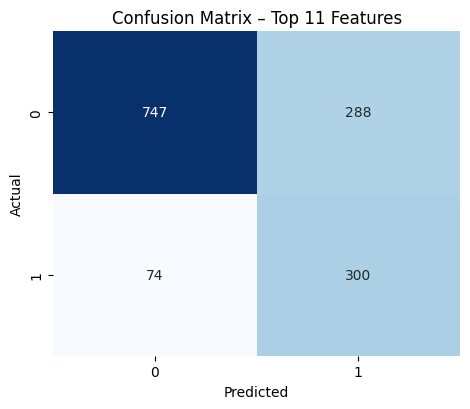

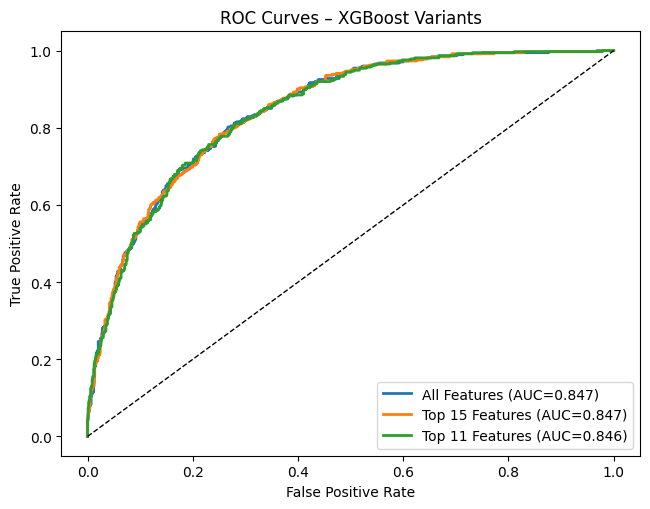

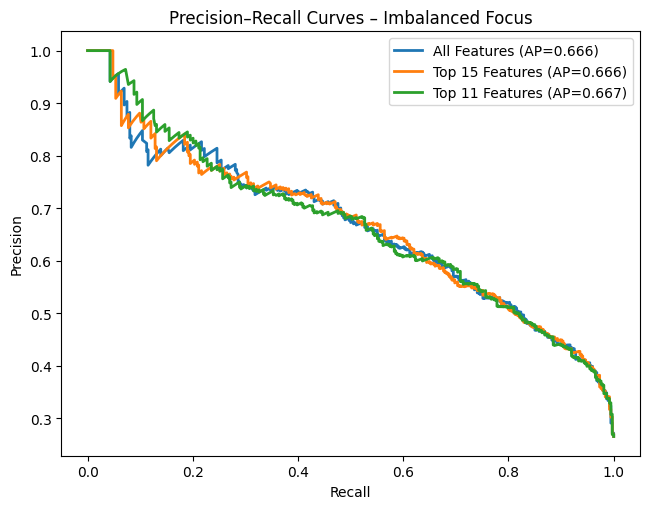

,Variant,F1,Precision,Recall,Accuracy,ROC_AUC,PR_AP,CV_Acc_Mean,CV_F1_Mean
0,All Features,0.629591,0.518135,0.802139,0.749468,0.846926,0.665654,0.752045,0.630025
1,Top 15 Features,0.624738,0.513793,0.796791,0.745919,0.847107,0.666387,0.752222,0.631110
2,Top 11 Features,0.623701,0.510204,0.802139,0.743080,0.845517,0.667456,0.750093,0.629398


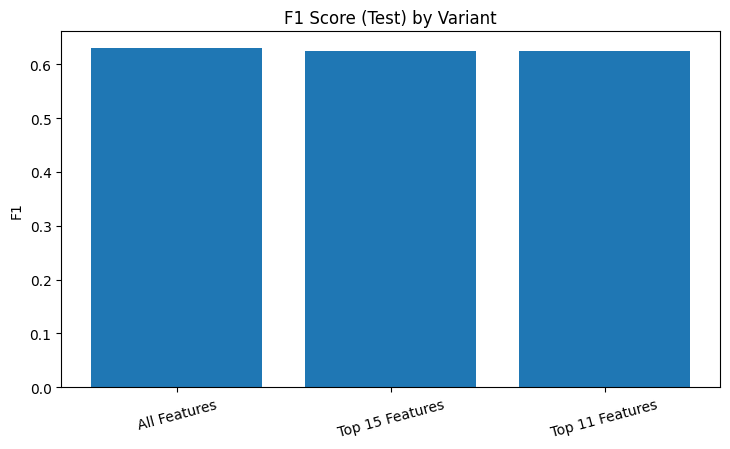

In [36]:
res_all   = evaluate_xgb(X, y, label="All Features")
res_top15 = evaluate_xgb(df[features_top15], y, label="Top 15 Features")
res_top11 = evaluate_xgb(df[features_top11], y, label="Top 11 Features")

# Combined ROC (Test)
plt.figure(figsize=(6.6, 5.2))
for res in (res_all, res_top15, res_top11):
    plt.plot(res["fpr"], res["tpr"], linewidth=2,
             label=f"{res['label']} (AUC={res['test_metrics']['roc_auc']:.3f})")
plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves – XGBoost Variants')
plt.legend(); plt.tight_layout(); plt.show()

# Combined PR (Test)
plt.figure(figsize=(6.6, 5.2))
for res in (res_all, res_top15, res_top11):
    plt.plot(res["recall_curve"], res["precision_curve"], linewidth=2,
             label=f"{res['label']} (AP={res['test_metrics']['ap']:.3f})")
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curves – Imbalanced Focus')
plt.legend(); plt.tight_layout(); plt.show()

# Metrics summary
summary_rows = []
for res in (res_all, res_top15, res_top11):
    tm = res["test_metrics"]
    summary_rows.append({
        "Variant": res["label"],
        "F1": tm["f1"],
        "Precision": tm["precision"],
        "Recall": tm["recall"],
        "Accuracy": tm["accuracy"],
        "ROC_AUC": tm["roc_auc"],
        "PR_AP": tm["ap"],
        "CV_Acc_Mean": np.mean(res["cv_acc"]),
        "CV_F1_Mean": np.mean(res["cv_f1"]),
    })
summary_df = pd.DataFrame(summary_rows).sort_values("F1", ascending=False)
display(summary_df)

plt.figure(figsize=(7.4, 4.6))
plt.bar(summary_df["Variant"], summary_df["F1"])
plt.title("F1 Score (Test) by Variant")
plt.ylabel("F1"); plt.xticks(rotation=15)
plt.tight_layout(); plt.show()

**Save models (Drive) + export metrics CSV + “best by F1” note**

In [37]:
paths = {
    "All Features":    os.path.join(model_dir, "XGBoost – All Features.pkl"),
    "Top 15 Features": os.path.join(model_dir, "XGBoost – Top 15 Features.pkl"),
    "Top 11 Features": os.path.join(model_dir, "XGBoost – Top 11 Features.pkl"),
}

with open(paths["All Features"], 'wb') as f:    pickle.dump(res_all["model"], f)
with open(paths["Top 15 Features"], 'wb') as f: pickle.dump(res_top15["model"], f)
with open(paths["Top 11 Features"], 'wb') as f: pickle.dump(res_top11["model"], f)

# Metrics CSV
metrics_csv_path = os.path.join(model_dir, "XGB_Evaluation_Summary.csv")
summary_df.to_csv(metrics_csv_path, index=False)

# Best by F1
best = summary_df.iloc[0]
best_name = best["Variant"]
map_to_path = {
    "All Features": paths["All Features"],
    "Top 15 Features": paths["Top 15 Features"],
    "Top 11 Features": paths["Top 11 Features"]
}
best_note_path = os.path.join(model_dir, "Best_XGB_Model_By_F1.txt")
with open(best_note_path, "w") as f:
    f.write(
        f"Best Variant (by Test F1): {best_name}\n"
        f"F1={best['F1']:.4f}, Precision={best['Precision']:.4f}, "
        f"Recall={best['Recall']:.4f}, ROC_AUC={best['ROC_AUC']:.4f}, AP={best['PR_AP']:.4f}\n"
        f"Saved as: {map_to_path[best_name]}\n"
    )

print("Saved model files:")
for k, v in paths.items():
    print(f" - {k}: {v}")
print(f"\nMetrics CSV: {metrics_csv_path}")
print(f"Best-by-F1 note: {best_note_path}")

Saved model files:
 - All Features: /content/drive/MyDrive/CSE 4262 Project/XGB Model/XGBoost – All Features.pkl
 - Top 15 Features: /content/drive/MyDrive/CSE 4262 Project/XGB Model/XGBoost – Top 15 Features.pkl
 - Top 11 Features: /content/drive/MyDrive/CSE 4262 Project/XGB Model/XGBoost – Top 11 Features.pkl

Metrics CSV: /content/drive/MyDrive/CSE 4262 Project/XGB Model/XGB_Evaluation_Summary.csv
Best-by-F1 note: /content/drive/MyDrive/CSE 4262 Project/XGB Model/Best_XGB_Model_By_F1.txt
